In [1]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

import numpy as np

from astropy.io import fits
from astropy import wcs
from astropy import units as u
from astropy.nddata import Cutout2D
from astropy import coordinates
from astropy.coordinates import SkyCoord
from astropy.visualization import PercentileInterval

# Delete this if not in a notebook environment
%matplotlib notebook

In [2]:
# Open the FITS image
hdu = fits.open("1069429152_139-147MHz_YY_r-1.0_v2.1_pb.fits")
print hdu[0].data.shape
# Just grab the image data
imdata = np.squeeze(hdu[0].data)
print imdata.shape

(1, 1, 4000, 4000)
(4000, 4000)


In [3]:
# Full WCS co-ordinates include polarisation and frequency axes
w = wcs.WCS(hdu[0].header)

In [4]:
w

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 56.35866  -26.736429999999999  142715000.0  -6.0  
CRPIX : 1965.3150000000001  2002.0709999999999  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0090909000000000007  0.0090909000000000007  7680000.0000000596  1.0  
NAXIS : 4000  4000  1  1

In [5]:
# But we only really want the RA and Dec co-ordinates
w = wcs.WCS(hdu[0].header, naxis=2)

In [6]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 56.35866  -26.736429999999999  
CRPIX : 1965.3150000000001  2002.0709999999999  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0090909000000000007  0.0090909000000000007  
NAXIS : 4000  4000  1  1

<IPython.core.display.Javascript object>


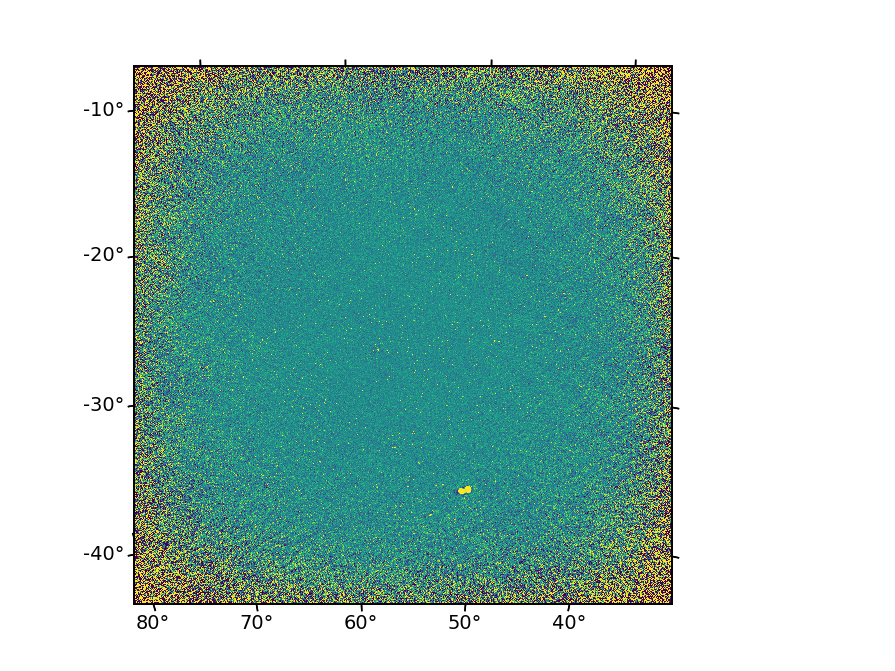

In [7]:
# Start making our plot
fig = plt.figure()
# Note how this *axis* is in WCS co-ordinate projection
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection = w)
# Plotting the whole image is a bit pointless because we can't see anything!
img = ax.imshow(imdata, cmap="cubehelix")

In [8]:
# Let's scale the minimum and maximum brightness so we can see more details (scroll up to see the result)
interval = PercentileInterval(90.0)
vmin, vmax = interval.get_limits(imdata)
img = ax.imshow(imdata, vmin=vmin, vmax=vmax)

In [9]:
# Now let's plot a region around Fornax A
# First get the co-ordinates -- online if you have internet, or set them manually otherwise
try:
    fornax = coordinates.get_icrs_coordinates("Fornax A")
except:
    fornax = SkyCoord("50.75 -37.25", unit=(u.deg, u.deg))

In [12]:
print fornax

240.162730471


In [13]:
# Define a smallish cutout region
framesize = 3*u.deg

In [14]:
# Use the Cutout2D method to select that particular region
cutout = Cutout2D(imdata, fornax, framesize, wcs = w)

<IPython.core.display.Javascript object>


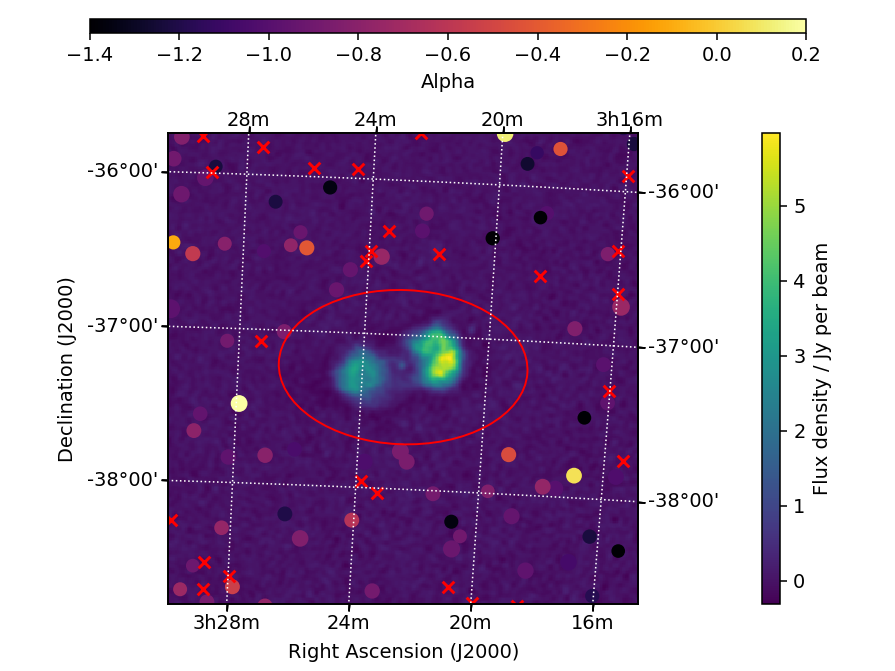

In [15]:
# Plot our small region
# Note that we need to create a new axis because the old one was in WCS for the *whole* image
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.7, 0.7], projection = cutout.wcs)
img = ax.imshow(cutout.data)

In [16]:
# Format the axis labels)
lat = ax.coords["dec"]
lat.set_axislabel("Declination (J2000)")
lon = ax.coords["ra"]
lon.set_axislabel("Right Ascension (J2000)")
# If we do not specify the format, our co-ordinates will be in degrees
lon.set_major_formatter("hh:mm")

In [17]:
# Turn on an overlay (scroll up to see the result)
overlay = ax.get_coords_overlay("fk5")
overlay.grid(axes = ax, color="white", ls="dotted")
# Also make the overlay RA co-ordinates in hours
overlay["ra"].set_major_formatter("hh:mm")

In [19]:
# Scatter plot of GLEAM sources nearby
# Load the catalogue
cat = fits.open("GLEAM_EGC_v2.fits")
catalog = cat[1].data
srcs = SkyCoord(catalog["RAJ2000"]*u.deg, catalog["DEJ2000"]*u.deg)
# Grab the source brightnesses and spectral indices
alpha = catalog["alpha"]
fluxd = catalog["int_flux_wide"]

In [20]:
# Find the catalogue entries which are nearby
#idx, idxcatalog, d2d, d3d = srcs.search_around_sky(fornax, framesize)
idx = np.where(srcs.separation(fornax)<framesize)
# Useful when you combine matplotlib markers and fits images so that the image doesn't automatically rescale out and leave blank pixels
ax.autoscale(False)
# Plot the sources: sources with spectral indices as coloured circles, those without as markers
bright = np.logical_not(np.isnan(alpha[idx]))
dim = np.isnan(alpha[idx])
points = ax.scatter(srcs[idx][bright].fk5.ra.value, srcs[idx][bright].fk5.dec.value, c = alpha[idx][bright], s = 20*np.log10(1000*fluxd[idx][bright]), marker="o", transform = ax.get_transform("fk5"), vmin = -1.4, vmax = 0.2, cmap="inferno")
ax.scatter(srcs[idx][dim].fk5.ra.value, srcs[idx][dim].fk5.dec.value, marker="x", color="red", transform = ax.get_transform("fk5"))

In [23]:
# Try plotting a big ellipse circling Fornax A
# Note that everything is in WCS co-ordinates, including the ellipse size and angle!
ax.add_patch(Ellipse((fornax.fk5.ra.value, fornax.fk5.dec.value),
                    width = 2, height = 1, angle = 0.0,
                     facecolor = "none",
                     edgecolor = "red",
                     transform = ax.get_transform("fk5")
                     ))

In [21]:
# Add a colorbar
cbaxes_img = fig.add_axes([0.85, 0.1, 0.02, 0.7])
cb_img = plt.colorbar(img, cax = cbaxes_img, orientation="vertical")
cb_img.set_label("Flux density / Jy per beam")

In [22]:
# And another for the alpha values
cbaxes_alpha = fig.add_axes([0.1, 0.95, 0.8, 0.02])
cb_alpha = plt.colorbar(points, cax = cbaxes_alpha, orientation="horizontal")
cb_alpha.set_label("Alpha")

In [ ]:
fig.savefig("example_plot.pdf")